In [0]:
# Cell 1: Create the Bronze/Silver/Gold directory structure
dbutils.fs.mkdirs("/Volumes/workspace/default/rbi_cash/bronze/")
dbutils.fs.mkdirs("/Volumes/workspace/default/rbi_cash/silver/")
dbutils.fs.mkdirs("/Volumes/workspace/default/rbi_cash/gold/")

print("Bronze, Silver, and Gold directories created in your Volume.")

Bronze, Silver, and Gold directories created in your Volume.


In [0]:
# Cell 2: Move your raw file to the Bronze zone
# ❗ Note: This code assumes your original Excel file is in the root of the 'rbi_cash' volume.
# If you uploaded it elsewhere, adjust the first path accordingly.

dbutils.fs.mv(
    "/Volumes/workspace/default/rbi_cash/rbi_cash_data.xlsx", 
    "/Volumes/workspace/default/rbi_cash/bronze/rbi_cash_data.xlsx"
)

print("✅ Raw Excel file moved to the Bronze zone.")

✅ Raw Excel file moved to the Bronze zone.


In [0]:
pip install openpyxl

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
# Cell 3: Ingestion Script (Bronze to Silver)
import pandas as pd

# Define the file paths using your specific workspace structure
bronze_path = "/Volumes/workspace/default/rbi_cash/bronze/rbi_cash_data.xlsx"
silver_path = "/Volumes/workspace/default/rbi_cash/silver/"

# Read the multi-sheet Excel file
xls = pd.ExcelFile(bronze_path)
sheet_names = xls.sheet_names

# Loop through each sheet and save it as a separate CSV file in the Silver zone
for sheet in sheet_names:
    df_pandas = pd.read_excel(xls, sheet_name=sheet, header=2)
    df_pandas.to_csv(f"{silver_path}{sheet}.csv", index=False)

print(f"✅ Ingestion complete: {len(sheet_names)} sheets from Bronze have been saved as separate CSVs in the Silver zone.")

✅ Ingestion complete: 65 sheets from Bronze have been saved as separate CSVs in the Silver zone.


In [0]:
# Cell 4: The Spark Job (Silver to Gold)
from pyspark.sql.functions import col, expr

# 1. Read all 65 CSV files from the Silver Zone into a single Spark DataFrame
# Spark will automatically read all files in this directory.
silver_df = spark.read.format("csv") \
    .option("header", "true") \
    .option("inferSchema", "false") \
    .load("/Volumes/workspace/default/rbi_cash/silver/")

# 2. Apply the cleaning and transformation logic
# We select, rename, and safely cast the data types, dropping any invalid rows.
transformed_df = silver_df.select(
    col("`Unnamed: 0`").alias("Date"),  # Use backticks for columns with special characters
    col("`Unnamed: 35`").alias("ATMCashWithdrawal_Value")
).withColumn(
    "Date", expr("try_cast(Date as date)")
).withColumn(
    "ATMCashWithdrawal_Value", expr("try_cast(ATMCashWithdrawal_Value as double)")
).na.drop()

# 3. Write the final DataFrame to a managed Hive table (Gold Zone)
# This creates a permanent, structured table for your analytics.
transformed_df.write \
    .mode("overwrite") \
    .saveAsTable("atm_forecast_gold")

print("✅ Spark job complete! Clean data has been processed from Silver and saved to the 'atm_forecast_gold' Hive table.")

✅ Spark job complete! Clean data has been processed from Silver and saved to the 'atm_forecast_gold' Hive table.


In [0]:
pip install prophet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.4/14.4 MB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 42.5 MB/s eta 0:00:00
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
pip install calplot

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for calplot: filename=calplot-0.1.7.5-py3-none-any.whl size=8115 sha256=1d2364f9a1b934d3f9e9d8f6639734e599537826a5f0ffe4927c0940ccd201ac
  Stored in directory: /home/spark-f1fc8f18-4a0b-43c1-8c28-ff/.cache/pip/wheels/f1/eb/af/79f8750a9f757aa0ccb6a0e217515abf3892f989345e98e50c
Successfully built calplot
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


17:48:35 - cmdstanpy - INFO - Chain [1] start processing
17:48:35 - cmdstanpy - INFO - Chain [1] done processing


--- 💡 Final Dashboard Visualizations 💡 ---

1. Main Forecast Plot:


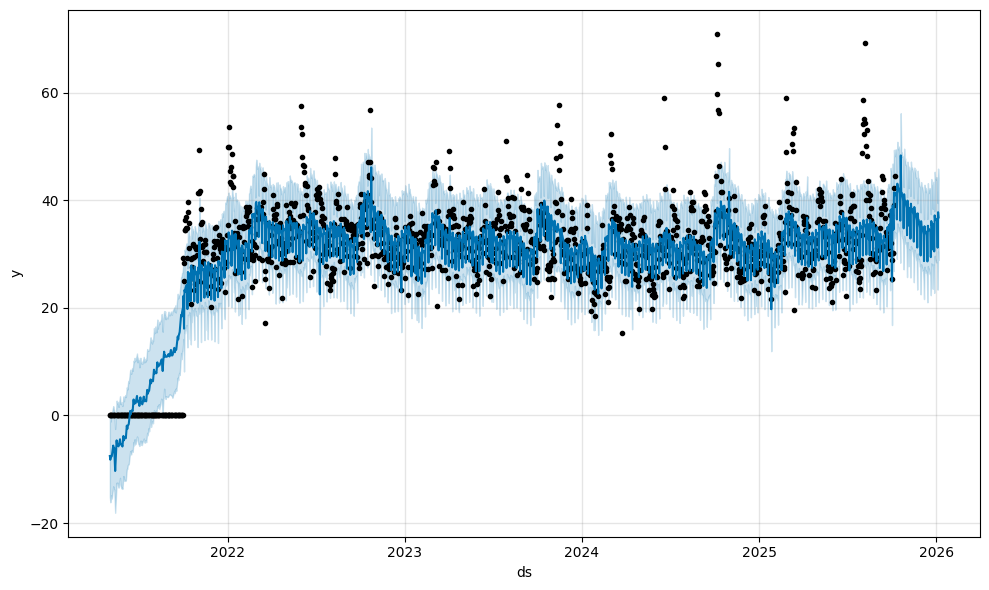


2. Forecast Components Plot:

3. Calendar Heatmap Visualization:


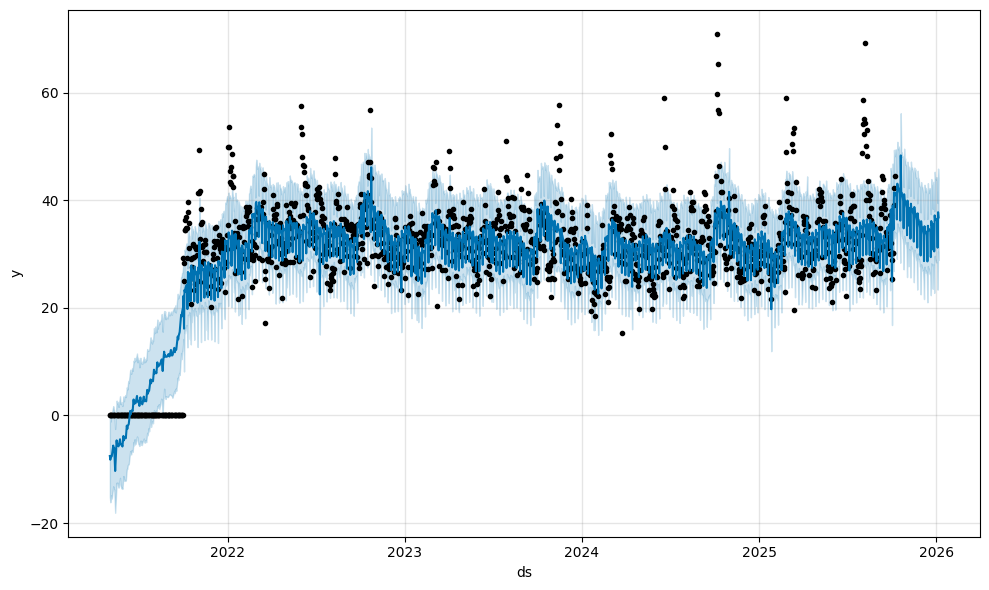

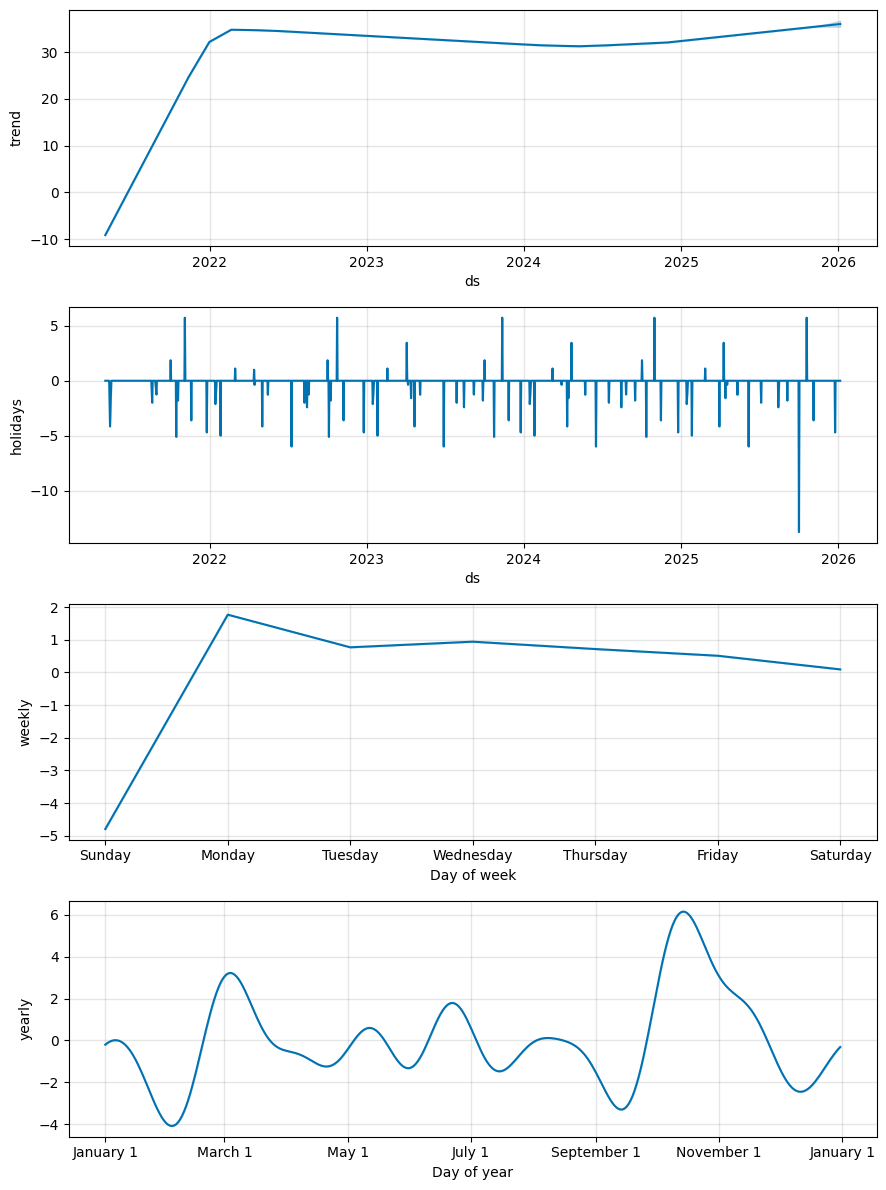

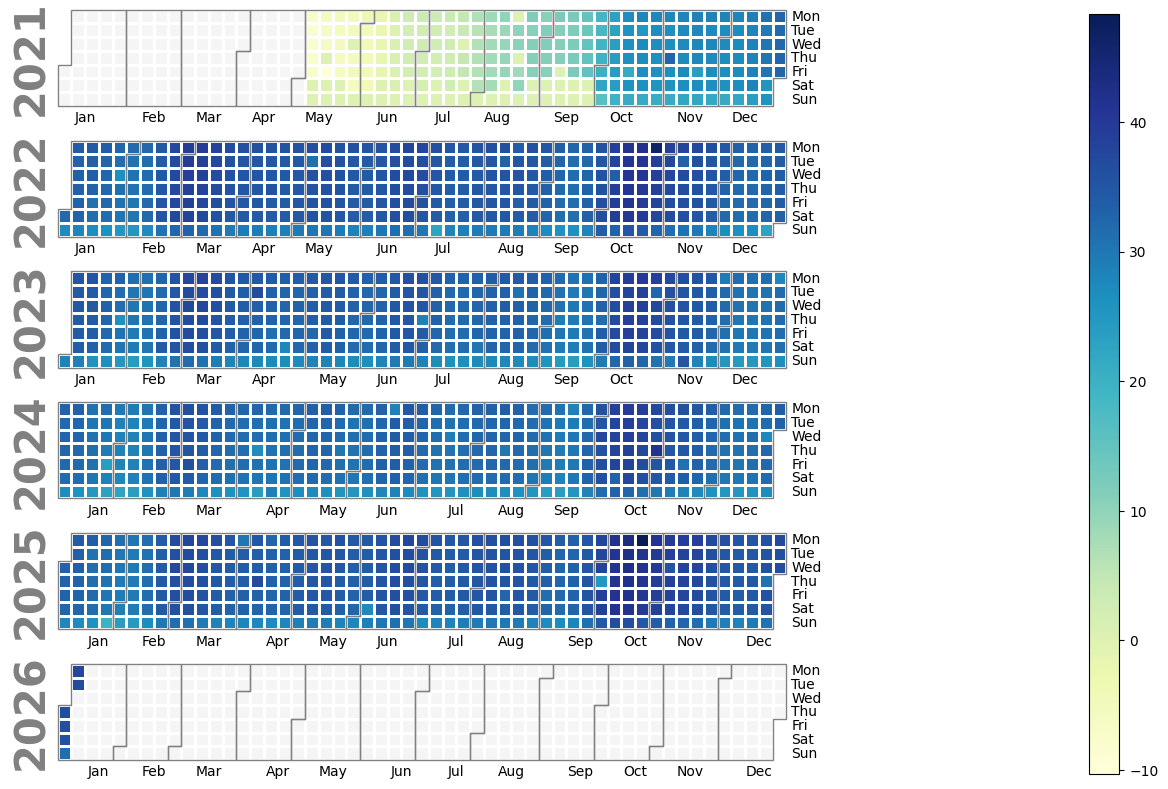

In [0]:
# Cell 5: Read from Hive, Forecast, and Visualize
import pandas as pd
from prophet import Prophet
import holidays
import calplot
import logging

# Silence the persistent font warnings
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

# 1. Read the clean data from your Gold Hive table
gold_df_pandas = spark.table("atm_forecast_gold").toPandas()

# 2. Prepare the DataFrame for Prophet ('ds', 'y')
df_prophet = gold_df_pandas.rename(columns={
    "Date": "ds",
    "ATMCashWithdrawal_Value": "y"
})

# 3. Build and run the final Prophet model with holidays
years = list(range(2021, 2026)) 
tn_holidays = holidays.country_holidays('IN', subdiv='TN', years=years)
holidays_df = pd.DataFrame(sorted(tn_holidays.items()), columns=['ds', 'holiday'])

model = Prophet(holidays=holidays_df)
model.fit(df_prophet)
future = model.make_future_dataframe(periods=90)
forecast = model.predict(future)

print("--- 💡 Final Dashboard Visualizations 💡 ---")

# 4. Generate the dashboard plots
print("\n1. Main Forecast Plot:")
fig1 = model.plot(forecast)
display(fig1)

print("\n2. Forecast Components Plot:")
fig2 = model.plot_components(forecast)


print("\n3. Calendar Heatmap Visualization:")
forecast_for_heatmap = forecast.set_index('ds')['yhat']
fig3, ax = calplot.calplot(forecast_for_heatmap, cmap='YlGnBu', figsize=(15, 8))


In [0]:
# Cell 6: KPIs and Actionable Insights

import pandas as pd

# --- FIX: Convert the 'ds' column to a proper datetime format ---
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])
# -------------------------------------------------------------

# Calculate KPIs from the model and data
future_forecast = forecast[forecast['ds'] > df_prophet['ds'].max()]
peak_day = future_forecast.loc[future_forecast['yhat'].idxmax()]
avg_monday = df_prophet[df_prophet['ds'].dt.dayofweek == 0]['y'].mean()
avg_sunday = df_prophet[df_prophet['ds'].dt.dayofweek == 6]['y'].mean()
weekly_fluctuation = ((avg_monday - avg_sunday) / avg_sunday) * 100

print("--- ✅ Key Performance Indicators (KPIs) ---")
print(f"📈 KPI 1 - Next Peak Demand Day: The model predicts the highest demand will be on {peak_day['ds'].strftime('%Y-%m-%d')} with a value of {peak_day['yhat']:.2f} Crore.")
print(f"📅 KPI 2 - Average Weekly Fluctuation: On average, cash withdrawals on Mondays are {weekly_fluctuation:.2f}% higher than on Sundays, representing the most significant weekly pattern.")
print(f"🎉 KPI 3 - Holiday Impact: The model has quantified the specific financial impact of dozens of regional holidays, separating their effect from regular weekly trends (as shown in the components plot).")

print("\n\n--- 🚀 Actionable Business Recommendation ---")
print("Based on the clear and predictable weekly peak identified by our model, we recommend a strategic shift in cash logistics. The primary ATM refill schedule for high-traffic urban centers should be moved to Monday mornings. This will directly address the highest demand period, preventing ATM downtime, improving customer satisfaction, and optimizing operational efficiency.")

--- ✅ Key Performance Indicators (KPIs) ---
📈 KPI 1 - Next Peak Demand Day: The model predicts the highest demand will be on 2025-10-20 with a value of 48.33 Crore.
📅 KPI 2 - Average Weekly Fluctuation: On average, cash withdrawals on Mondays are 13.87% higher than on Sundays, representing the most significant weekly pattern.
🎉 KPI 3 - Holiday Impact: The model has quantified the specific financial impact of dozens of regional holidays, separating their effect from regular weekly trends (as shown in the components plot).


--- 🚀 Actionable Business Recommendation ---
Based on the clear and predictable weekly peak identified by our model, we recommend a strategic shift in cash logistics. The primary ATM refill schedule for high-traffic urban centers should be moved to Monday mornings. This will directly address the highest demand period, preventing ATM downtime, improving customer satisfaction, and optimizing operational efficiency.
